# Preliminaries
## Authors: Mariam Abdullah, Musonda Sinkala, Will Calandra

In [427]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
import numpy as np
from scipy.stats import t, ttest_ind
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Linear Regression Packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score

# Logistic Regression Packages
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# Neural Network Packages
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Recommendation packages
from surprise import Reader, Dataset
from surprise import SVD

import warnings
warnings.filterwarnings('ignore')

seed = 7

In [428]:
data = pd.read_csv("spotify52kData.csv")
song_df = pd.read_csv('spotify52kData.csv')

# Q1
Is there a relationship between song length and popularity of a song? If so, is it positive or negative?

In [429]:
song_df[['duration', 'popularity']].corr()

,duration,popularity
duration,1.000000,-0.054651
popularity,-0.054651,1.000000


In [430]:
# Compute the (floor of the) length of each song in minutes for bucketing popularity by.
df = song_df
df['minutes'] = df['duration'] // 60000

# Drop buckets with fewer than 10 songs to reduce variance.
df = df.groupby('minutes').filter(lambda x: len(x) >= 10)

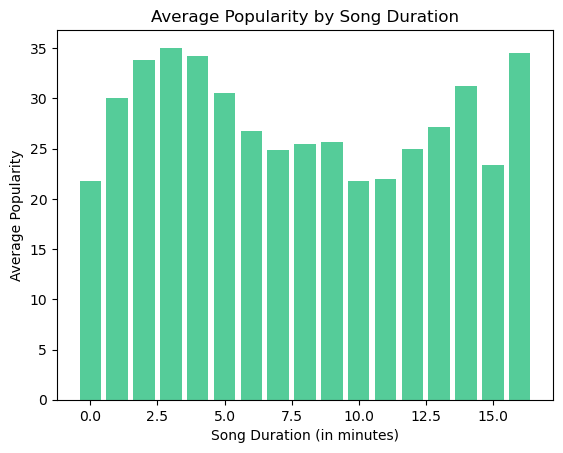

In [431]:
# Plot the average popularity per song duration in minutes.
x = sorted(set(df['minutes']))
y = df.groupby('minutes')['popularity'].mean().tolist()

plt.bar(x, height=y, color='#5c9')
plt.title('Average Popularity by Song Duration')
plt.xlabel('Song Duration (in minutes)')
plt.ylabel('Average Popularity')
plt.show()

Is there a relationship? From the plot it looks like there is.

In [432]:
# Fit a 4th order polynomial because it looks like it curves up and down 4 times.
def func(x, a, b, c, d, e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

popt, pcov = curve_fit(func, df['minutes'], df['popularity'])
y_pred = [func(i, *popt) for i in x]

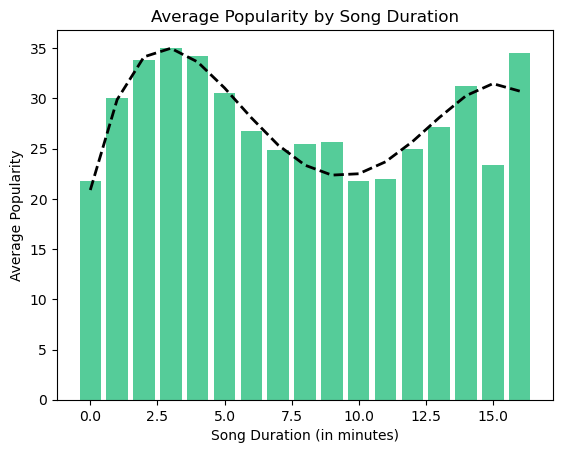

In [433]:
plt.bar(x, height=y, color='#5c9')
plt.plot(x, y_pred, '#000', linewidth=2, linestyle='dashed')
plt.title('Average Popularity by Song Duration')
plt.xlabel('Song Duration (in minutes)')
plt.ylabel('Average Popularity')
plt.show()

# Q2
Are explicitly rated songs more popular than songs that are not explicit?

In [434]:
song_df = pd.read_csv('spotify52kData.csv') #Read unmanipulated data afresh.

In [435]:
# Explicit and non explicit song popularities.
x1 = list(song_df[song_df['explicit']]['popularity'])
x2 = list(song_df[~song_df['explicit']]['popularity'])

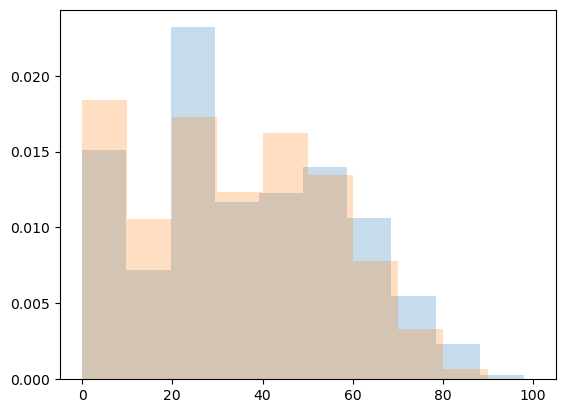

In [436]:
# Plot histograms.
plt.hist(x1, density=True, histtype='stepfilled', alpha=0.25)
plt.hist(x2, density=True, histtype='stepfilled', alpha=0.25)
plt.show()

These do not really look normally distributed due to too many popularity values of 0. If we remove these, the distributions look more normal.

In [437]:
# Get proportions of zeros.
print(x1.count(0) / len(x1))
print(x2.count(0) / len(x2))

0.10934429158477756
0.12417300605564295


In [438]:
# Get rid of zeros.
x1 = [x for x in x1 if x > 0]
x2 = [x for x in x2 if x > 0]

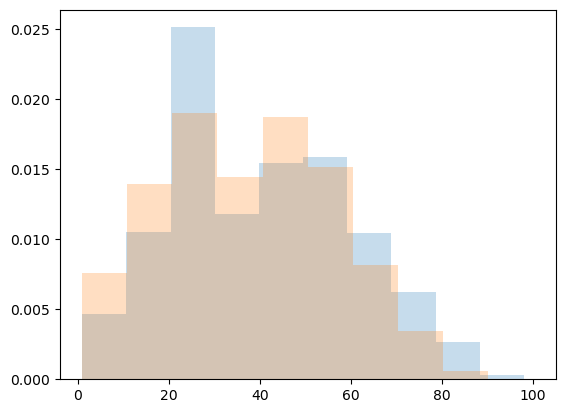

In [439]:
# Re-plot histograms.
plt.hist(x1, density=True, histtype='stepfilled', alpha=0.25)
plt.hist(x2, density=True, histtype='stepfilled', alpha=0.25)
plt.show()

In [440]:
# Print variances.
print(pd.Series(x1).var())
print(pd.Series(x2).var())

396.6281136346432
359.4237669894404


In [441]:
# Print p-values for both independent-T and Welch since variances are somewhat close.
print(ttest_ind(x1, x2, equal_var=True).pvalue)
print(ttest_ind(x1, x2, equal_var=False).pvalue)

3.76297219956625e-22
1.6340357801246936e-20


In [442]:
# Fit a T-distribution to each and look at mean and variance.
print(t.fit(x1)[1:])
print(t.fit(x2)[1:])

(40.2098859065476, 19.913396180043236)
(37.439932308300726, 18.957843973363005)


In [443]:
def plot_t(samples, color):
    df = len(samples) - 1
    _, mu, std = t.fit(samples)
    x = np.linspace(-3, 3, 600)
    plt.plot(x * std + mu, t.pdf(x, df) / std, color=color, alpha=0.75, linewidth=4)

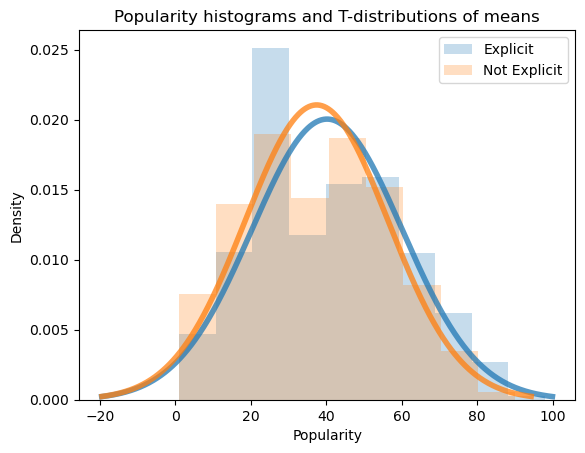

In [444]:
# Plot histograms.
plt.hist(x1, density=True, histtype='stepfilled', alpha=0.25)
plt.hist(x2, density=True, histtype='stepfilled', alpha=0.25)

# Plot T-distribution mean estimates.
plot_t(x1, '#1f77b4')
plot_t(x2, '#ff7f0e')

plt.title('Popularity histograms and T-distributions of means')
plt.xlabel('Popularity')
plt.ylabel('Density')
plt.legend(["Explicit", "Not Explicit"])
plt.show()

This plot clearly shows that explicit songs have higher popularity.

# Q3
Are songs in major key more popular than songs in minor key?

In [445]:
song_df = pd.read_csv('spotify52kData.csv')

In [446]:
# Major and minor key song popularities.
x1 = list(song_df[song_df['mode'] == 1]['popularity'])
x2 = list(song_df[song_df['mode'] == 0]['popularity'])

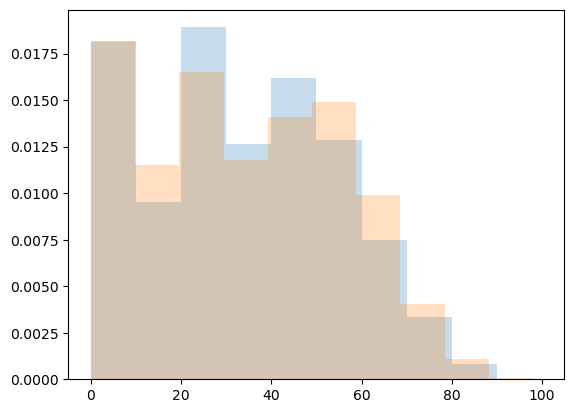

In [447]:
# Plot histograms.
plt.hist(x1, density=True, histtype='stepfilled', alpha=0.25)
plt.hist(x2, density=True, histtype='stepfilled', alpha=0.25)
plt.show()

In [448]:
# Get proportions of zeros.
print(x1.count(0) / len(x1))
print(x2.count(0) / len(x2))

0.12944953845203916
0.11122443775817227


In [449]:
# Get rid of zeros.
x1 = [x for x in x1 if x > 0]
x2 = [x for x in x2 if x > 0]

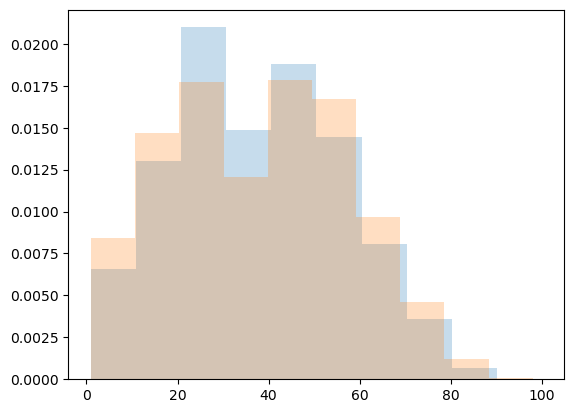

In [450]:
# Re-plot histograms.
plt.hist(x1, density=True, histtype='stepfilled', alpha=0.25)
plt.hist(x2, density=True, histtype='stepfilled', alpha=0.25)
plt.show()

In [451]:
# Print variances.
print(pd.Series(x1).var())
print(pd.Series(x2).var())

349.5681285067364
387.91198028935685


In [452]:
# Print p-values for both independent-T and Welch since variances are somewhat close.
print(ttest_ind(x1, x2, equal_var=True).pvalue)
print(ttest_ind(x1, x2, equal_var=False).pvalue)

0.10848925663121863
0.11286796649949958


In [453]:
# Check the mean and std of each.
print(t.fit(x1)[1:])
print(t.fit(x2)[1:])

(37.63029576390235, 18.69705780678045)
(37.92399737106197, 19.69511178799808)


In [454]:
def plot_t(samples, color):
    df = len(samples) - 1
    _, mu, std = t.fit(samples)
    x = np.linspace(-3, 3, 600)
    plt.plot(x * std + mu, t.pdf(x, df) / std, color=color, alpha=0.75, linewidth=4)

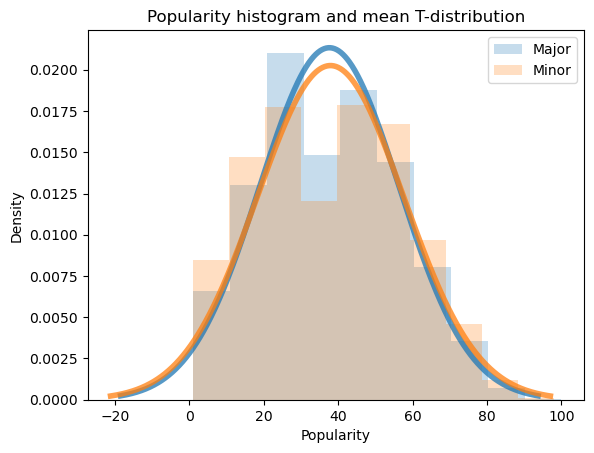

In [455]:
# Plot histograms.
plt.hist(x1, density=True, histtype='stepfilled', alpha=0.25)
plt.hist(x2, density=True, histtype='stepfilled', alpha=0.25)

# Plot mean estimates.
plot_t(x1, '#1f77b4')
plot_t(x2, '#ff7f0e')

plt.title('Popularity histogram and mean T-distribution')
plt.xlabel('Popularity')
plt.ylabel('Density')
plt.legend(["Major", "Minor"])
plt.show()

The Welch test shows that the difference in means is significant since p=1.66e-6. Our plot shows these two are very close but we can tell that songs in minor key have slightly higher popularity.

# Q4
Which of the following 10 song features: duration, danceability, energy, loudness, speechiness,
acousticness, instrumentalness, liveness, valence and tempo predicts popularity best?

In [456]:
song_df = pd.read_csv('spotify52kData.csv')

In [457]:
features = [
    'duration',
    'danceability',
    'energy',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo'
]

In [458]:
# Define the list of features and the target variable
features = ['duration', 'danceability', 'energy', 'loudness', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
target = 'popularity'

# Initialize an empty dictionary to store R-squared values for each feature
r_squared_values = {}

# Build and evaluate a simple linear regression model for each feature
for feature in features:
    # Select the current feature and the target variable
    X = data[[feature]]
    y = data[target]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

    # Initialize and fit the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate R-squared and store it in the dictionary
    r_squared = r2_score(y_test, y_pred)
    r_squared_values[feature] = r_squared

# Display R-squared values for each feature
for feature, r_squared in r_squared_values.items():
    print(f'R-squared for {feature}: {r_squared*100}')

# Identify the feature with the highest R-squared value
best_feature = max(r_squared_values, key=r_squared_values.get)
print(f'\nThe feature that predicts popularity best: {best_feature}')

R-squared for duration: 0.2895917125502967
R-squared for danceability: 0.060018087100188744
R-squared for energy: 0.2031286714536895
R-squared for loudness: 0.38763407134496664
R-squared for speechiness: 0.15412420634389745
R-squared for acousticness: 0.011516238056463735
R-squared for instrumentalness: 2.423589744301058
R-squared for liveness: 0.02666909116665339
R-squared for valence: 0.14979845511349232
R-squared for tempo: -0.008113999204995004

The feature that predicts popularity best: instrumentalness


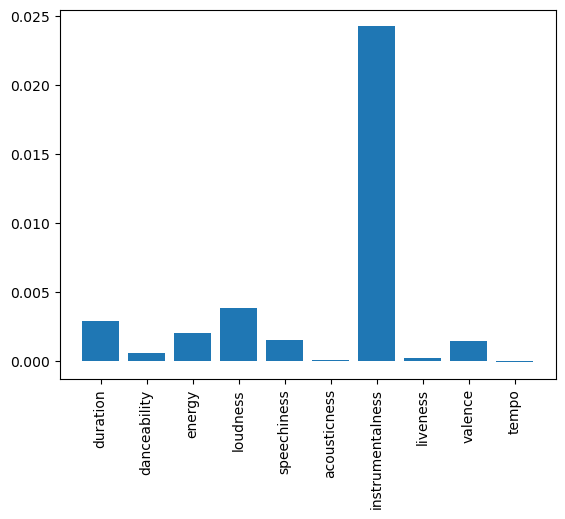

In [459]:
r2s = []
for f in features:
    x_train, x_test, y_train, y_test = train_test_split(
        song_df[[f]],
        song_df['popularity'],
        test_size=0.2,
        random_state=seed
    )
    ols = LinearRegression()
    ols.fit(x_train, y_train)
    r2s.append(r2_score(y_test, ols.predict(x_test)))

plt.bar(features, height=r2s)
plt.xticks(rotation=90)
plt.show()

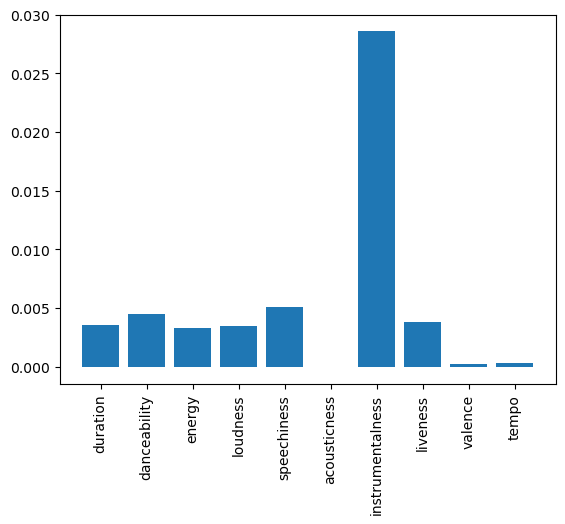

In [460]:
r2s = []
for f in features:
    x_train, x_test, y_train, y_test = train_test_split(
        song_df[[f]],
        song_df['popularity'] ** 2,
        test_size=0.2,
        random_state=seed
    )
    ols = LinearRegression()
    ols.fit(x_train, y_train)
    r2s.append(r2_score(y_test, ols.predict(x_test)))

plt.bar(features, height=r2s)
plt.xticks(rotation=90)
plt.show()

# Q5
Building a model that uses *all* of the song features mentioned in question 1, how well can you
predict popularity? How much (if at all) is this model improved compared to the model in question
4). How do you account for this? What happens if you regularize your model?

In [461]:
song_df = pd.read_csv('spotify52kData.csv')

In [462]:
features = [
    'duration',
    'danceability',
    'energy',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo'
]

<Axes: >

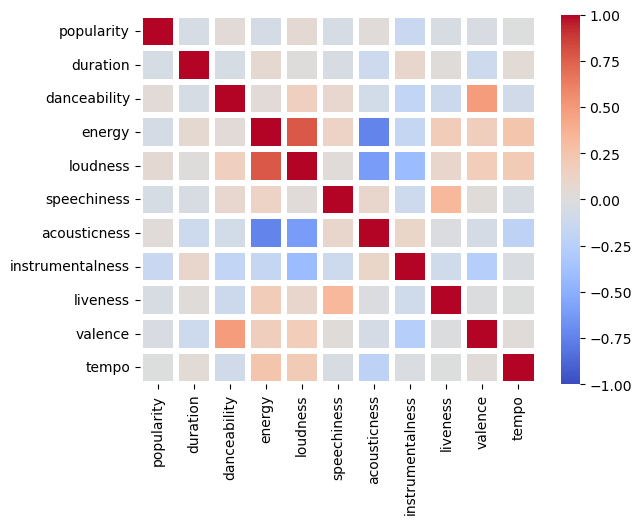

In [463]:
df = song_df[["popularity"] + features]
sns.heatmap(df.corr(), cmap="coolwarm", vmin=-1, vmax=1, linewidth=4)

In [464]:
# Alphas to try in grid search.
grid = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5]

In [465]:
# Training features and labels.
x_train, x_test, y_train, y_test = train_test_split(
    song_df[features],
    song_df['popularity'],
    test_size=0.2,
    random_state=seed
)

In [466]:
# Ordinary least squares.
ols = LinearRegression()
ols.fit(x_train, y_train)
print("OLS: {:0.6f}".format(r2_score(y_test, ols.predict(x_test))))

# Lasso with grid search.
lasso = GridSearchCV(Lasso(), param_grid={'alpha': grid})
lasso.fit(x_train, y_train)
print("Lasso: {:0.6f}".format(r2_score(y_test, lasso.predict(x_test))))

# Ridge regression with grid search.
ridge = GridSearchCV(Ridge(), param_grid={'alpha': grid})
ridge.fit(x_train, y_train)
print("Ridge: {:0.6f}".format(r2_score(y_test, ridge.predict(x_test))))

OLS: 0.046972
Lasso: 0.046972
Ridge: 0.046974


In [467]:
# Training features and labels.
x_train, x_test, y_train, y_test = train_test_split(
    song_df[features],
    song_df['popularity'] ** 2,
    test_size=0.2,
    random_state=seed
)

In [468]:
# Ordinary least squares.
ols = linear_model.LinearRegression()
ols.fit(x_train, y_train)
print("OLS: {:0.6f}".format(r2_score(y_test, ols.predict(x_test))))

# Lasso with grid search.
lasso = GridSearchCV(linear_model.Lasso(), param_grid={'alpha': grid})
lasso.fit(x_train, y_train)
print("Lasso: {:0.6f}".format(r2_score(y_test, lasso.predict(x_test))))

# Ridge regression with grid search.
ridge = GridSearchCV(linear_model.Ridge(), param_grid={'alpha': grid})
ridge.fit(x_train, y_train)
print("Ridge: {:0.6f}".format(r2_score(y_test, ridge.predict(x_test))))

OLS: 0.060176
Lasso: 0.060176
Ridge: 0.060175


# Q6
When considering the 10 song features in the previous question, how many meaningful principal
components can you extract? What proportion of the variance do these principal components
account for? Using these principal components, how many clusters can you identify? Do these
clusters reasonably correspond to the genre labels in column 20 of the data?

In [469]:
song_df = pd.read_csv('spotify52kData.csv')

In [470]:
features = [
    'duration',
    'danceability',
    'energy',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo'
]

In [471]:
# Normalize before doing PCA.
df = song_df[features]
df = (df - df.min()) / (df.max() - df.min())

In [472]:
# Find how many components explain ~95% of the variance.
pca = PCA(n_components=10)
pca.fit(df)
pca.explained_variance_ratio_

array([0.36702999, 0.24270606, 0.14217229, 0.09338626, 0.05037724,
       0.04191608, 0.02829733, 0.02654385, 0.00627816, 0.00129275])

In [473]:
# 6 principal components explain 93.76% of the variance. Transform the data to this space.
pca = PCA(n_components=6)
t = pca.fit_transform(df)

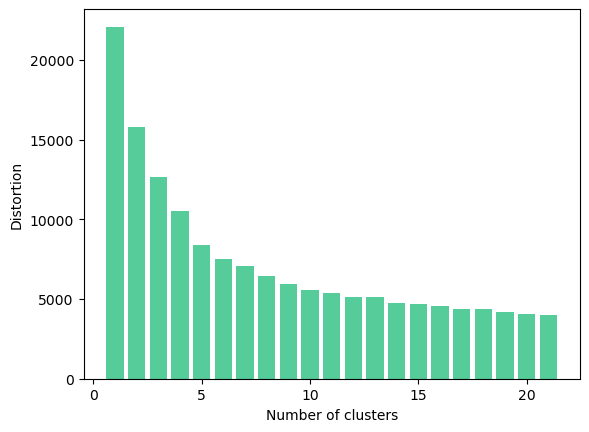

In [474]:
# Generate an elbow plot from kmeans inertias.
ks = range(1, 22)
inertias = [KMeans(n_clusters=k, n_init="auto").fit(t).inertia_ for k in ks]

plt.xlabel("Number of clusters")
plt.ylabel("Distortion")
plt.bar(ks, inertias, color='#5c9')
plt.show()

In [475]:
# Put songs into 5 clusters and label them.
song_df['cluster'] = KMeans(n_clusters=5, n_init="auto").fit(t).labels_

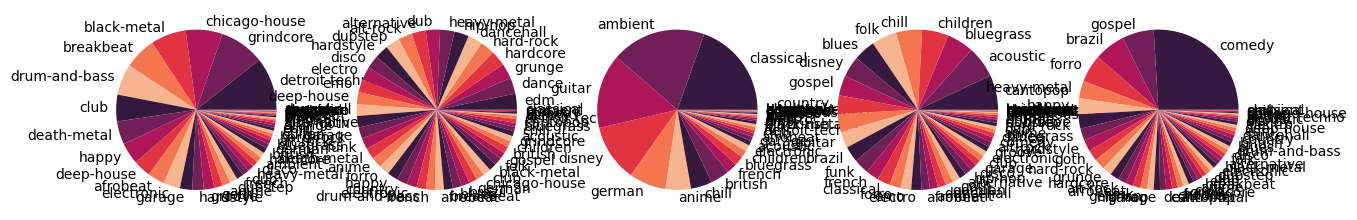

In [476]:
fig, axs = plt.subplots(1, 5, figsize=(15, 30))

for cluster, group in song_df.groupby('cluster'):
    counts = group.value_counts('track_genre').to_dict()
    axs[cluster].pie(counts.values(), labels=counts.keys(), colors=sns.color_palette("rocket"))

plt.show()

These clusters do not really correspond to song genre since many genres are split across multiple clusters. Some like "ambient" and "guitar" seem to do well though. But if we had a cluster for each of the 52 genres, would we do better?

In [477]:
# Put songs into 52 mini-clusters and label them.
song_df['mini_cluster'] = KMeans(n_clusters=52, n_init="auto").fit(t).labels_

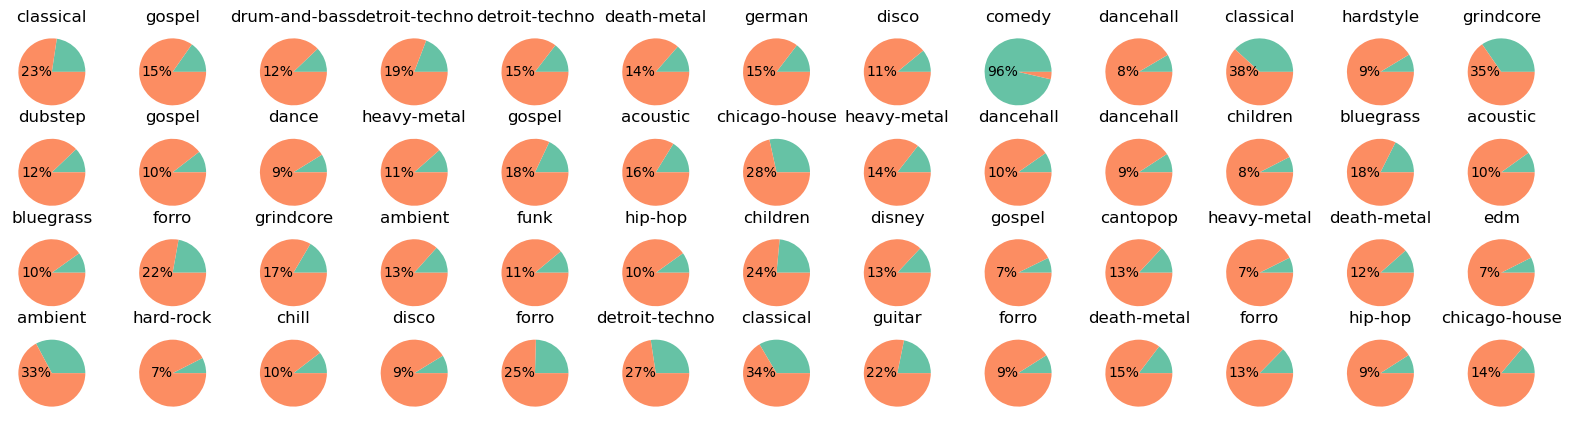

In [478]:
# Display the maximum genre in each mini-cluster.
fig, axs = plt.subplots(4, 13, figsize=(20, 5))

for cluster, group in song_df.groupby('mini_cluster'):
    counts = group.value_counts('track_genre').to_dict()
    keys, vals = zip(*counts.items())
    ax = axs[cluster % 4][cluster % 13]
    ax.set_title(keys[0])
    axs[cluster % 4][cluster % 13].pie(
        [vals[0], sum(vals[1:])],
        labels=["{:0.0f}%".format(100 * vals[0] / sum(vals)), ""],
        colors=sns.color_palette('Set2'),
        labeldistance=0
    )

plt.show()

This shows the maximum genre with its percent in each of 52 clusters. So even with 52 clusters we did not really do a good job separating genres, except for "comedy" and maybe "grindcore" or "classical".

# Q7

AUC for duration: 0.48
AUC for danceability: 0.55
AUC for energy: 0.55
AUC for loudness: 0.53
AUC for speechiness: 0.56
AUC for acousticness: 0.56
AUC for instrumentalness: 0.54
AUC for liveness: 0.51
AUC for valence: 0.50
AUC for tempo: 0.51


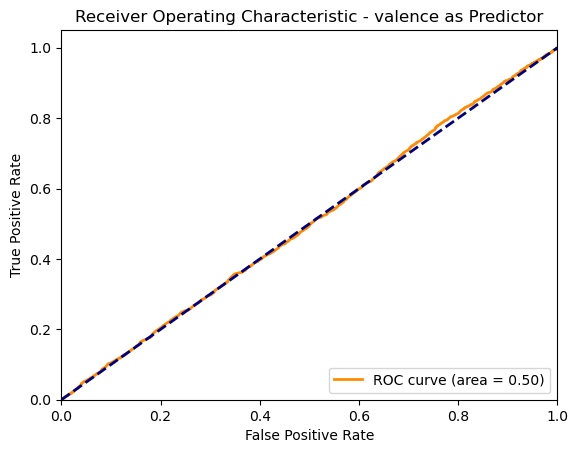

In [479]:
# Select features and target variable
target = 'mode'

# Initialize variables for ROC curve plotting
fpr_valence, tpr_valence, _ = roc_curve(data[target], data['valence'])
roc_auc_valence = auc(fpr_valence, tpr_valence)

# Initialize variables to store AUC values
auc_values = {}

# Iterate over each feature
for feature in features:
    # Select the current feature and the target variable
    X = data[[feature]]
    y = data[target]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    # Initialize and fit the logistic regression model
    model = LogisticRegression(random_state=seed)
    model.fit(X_train, y_train)

    # Predict the probabilities for the positive class
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_values[feature] = auc(fpr, tpr)

    # Plot ROC curve for valence
    if feature == 'valence':
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_values[feature]:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic - {feature} as Predictor')
        plt.legend(loc="lower right")

# Display AUC values for each feature
for feature, auc_val in auc_values.items():
    print(f'AUC for {feature}: {auc_val:.2f}')

plt.show()

# Q8

In [480]:
# Assuming your data is stored in a DataFrame named 'df'
# Extract features and target
features = ['duration', 'danceability', 'energy', 'loudness', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
target = 'track_genre'

X = data[features]
y = data['track_genre']

# Convert target labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size = 0.3, random_state = seed)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build and train the MLP classifier
model = MLPClassifier(
    hidden_layer_sizes = (128, 64),   # Two hidden layers with 128 and 64 units
    activation = 'relu',              # Rectified Linear Unit activation function
    max_iter = 50,                   # Increase the maximum number of iterations
    learning_rate_init = 0.001,      # Set a moderate initial learning rate
    random_state = seed
)
model.fit(X_train, y_train)

# Predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {round(accuracy * 100, 2)}')

Model Accuracy: 1.69


# Q9

In [481]:
# Read in data files fresh
spotify_df = pd.read_csv('spotify52kData.csv')
user_df = pd.read_csv('starRatings.csv', header=None)

In [482]:
# Check for duplicates
duplicates = spotify_df.iloc[:,1:-1].duplicated(keep=False) # Recall genre mislabeling, remove it
duplicates = spotify_df[duplicates]

# Filter for ratings of interest
duplicates = duplicates[duplicates['songNumber'] < 5000]

len(duplicates) , duplicates.nunique() # Goup by track name - it would presumably have the same album/artist by our first pass

(1789,
 songNumber          1789
 artists              427
 album_name           589
 track_name           937
 popularity            74
 duration             940
 explicit               2
 danceability         489
 energy               591
 key                   12
 loudness             934
 mode                   2
 speechiness          487
 acousticness         789
 instrumentalness     659
 liveness             526
 valence              629
 tempo                964
 time_signature         4
 track_genre            5
 dtype: int64)

In [483]:
# Grab indices of duplicate songs
group = duplicates.groupby('track_name')
groups_indices = [list(x) for x in group.groups.values()]

In [484]:
# Now loop through and concatenate ratings for the duplicate songs
series = []
indices = []

for i in range(len(groups_indices)):
    # Concatenate and average the data
    average = user_df[groups_indices[i]].mean(axis=1)
    index_to_keep = groups_indices[i][0]
    
    series.append(average)
    indices.append(index_to_keep)

In [485]:
# Drop duplicates and stich back aggregate ratings
indices_to_drop = np.concatenate(groups_indices)
dropped_df = user_df.drop(indices_to_drop, axis=1)
user_df = pd.concat([dropped_df, user_df[indices]], axis=1)

In [486]:
# Get popularity for each song, where no duplicates exist
popularity_df = spotify_df.iloc[user_df.columns, :]
popularity = popularity_df['popularity']
popularity_df.iloc[:,1:-1].duplicated(keep=False).sum(), user_df.duplicated(keep=False).sum() # No duplicates here

(0, 0)

In [487]:
# Check NA counts on each column
na_counts_song = user_df.isna().sum().sort_values() / len(user_df)
na_counts_song.head() # We don't have a lot of explicit feedback for each song

100     0.8898
275     0.8900
57      0.8901
2254    0.8909
4134    0.8910
dtype: float64

In [488]:
# Check NA counts on each row
na_counts_user = user_df.T.isna().sum().sort_values() / len(user_df.T)
na_counts_user.head() # Again, we retain very little explicit feedback

9027    0.881148
7583    0.881389
9231    0.881389
1482    0.882353
294     0.882353
dtype: float64

In [489]:
# Extract average rating for each song = P[i] = sum(R[u, i]) / cardinality(R[:,i])
song_avg = user_df.mean()
song_avg.head()

0    3.196939
2    2.186377
3    1.576998
4    3.038835
5    2.315735
dtype: float64

Text(0.5, 1.0, 'Scatterplot of Popularity v Avg Song Rating')

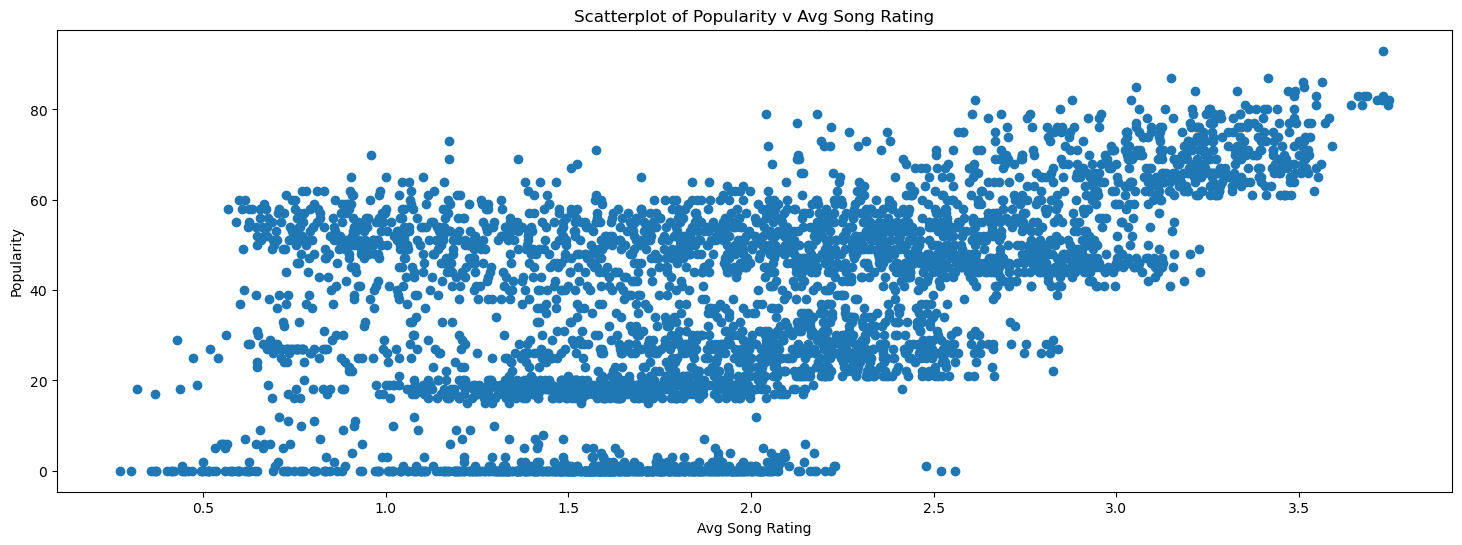

In [490]:
# Get a scatter plot popularity and average song rating
fig, ax = plt.subplots(figsize=(18,6))

ax.scatter(song_avg, popularity)
ax.set_xlabel('Avg Song Rating')
ax.set_ylabel('Popularity')
ax.set_title('Scatterplot of Popularity v Avg Song Rating')

Text(0.5, 1.0, 'Popularity Histogram')

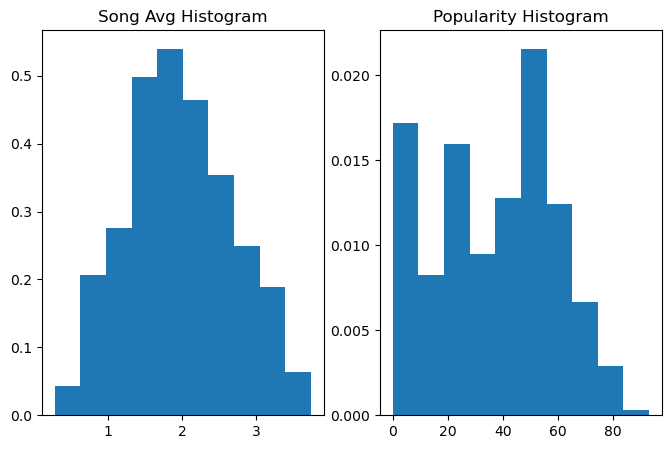

In [491]:
# Plot histograms of both
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.hist(song_avg, density=True)
plt.title('Song Avg Histogram') # Appears normal


plt.subplot(1,2,2)
plt.hist(popularity, density=True)
plt.title('Popularity Histogram') # Appears skewed

Text(0.5, 1.0, 'Popularity Boxplot')

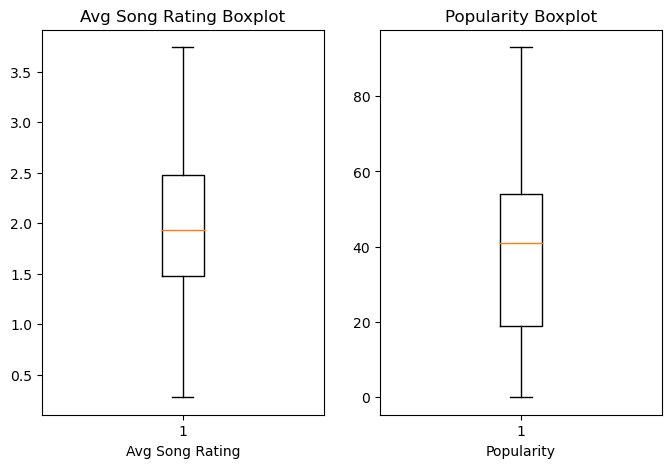

In [492]:
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.boxplot(song_avg)
plt.xlabel('Avg Song Rating')
plt.title('Avg Song Rating Boxplot')


plt.subplot(1,2,2)
plt.boxplot(popularity)
plt.xlabel('Popularity')
plt.title('Popularity Boxplot')

Text(0.5, 1.0, 'Scatterplot with Linear Fit of Average Rating on Popularity')

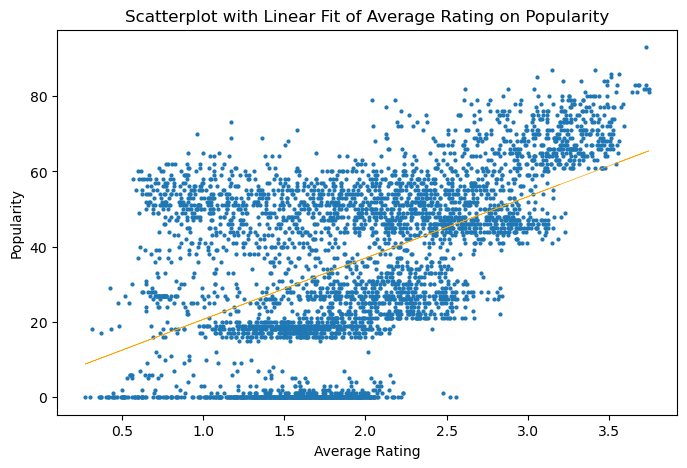

In [493]:
# Return a plot showing regression line
song_avg_arr = np.array(song_avg).reshape(-1,1) # going from shape (1000) -> (1000,1)

reg = LinearRegression()

# fit our model on the data
reg.fit(song_avg_arr, popularity)

# Calculate y_hat
y_hat = float(reg.coef_)*song_avg_arr + reg.intercept_

# Plotting our ground truth and our predictions
plt.figure(figsize=(8,5))
plt.plot(song_avg_arr, popularity, 'o', ms=2)
plt.plot(song_avg_arr, y_hat, color='orange', linewidth=0.5) # orange line for the fox
plt.xlabel('Average Rating')
plt.ylabel('Popularity')
plt.title('Scatterplot with Linear Fit of Average Rating on Popularity')

In [494]:
print(f'Mean of Average Song Rating is {round(np.mean(song_avg),1)} and mean of Popularity is {round(np.mean(popularity),1)}')
print(f'Std of Average Song Rating is {round(np.std(song_avg),1)} and std of Popularity is {round(np.std(popularity),1)}')

# Spearman rank
print('The Spearman Rank Correlation between average song rating and popularity is : ' + str(song_avg.corr(popularity, method='spearman')))

Mean of Average Song Rating is 2.0 and mean of Popularity is 36.5
Std of Average Song Rating is 0.7 and std of Popularity is 22.4
The Spearman Rank Correlation between average song rating and popularity is : 0.499063580788374


In [495]:
# Discretize popularity into quartiles, then run a one-way ANOVA on it
quartiles = pd.qcut(popularity, q=4, labels=False)

test_df = pd.concat([song_avg, quartiles], axis=1)
test_df.columns = ['Avg Song Rating', 'Popularity Quartile']
test_df.head()

,Avg Song Rating,Popularity Quartile
0,3.196939,3
2,2.186377,3
3,1.576998,3
4,3.038835,3
5,2.315735,3


In [496]:
# Get summary statistics
summary = test_df.groupby('Popularity Quartile').describe()
summary

Avg Song Rating                                          \
                              count      mean       std       min       25%   
Popularity Quartile                                                           
0                            1085.0  1.504047  0.394161  0.274757  1.310782   
1                            1001.0  1.870505  0.531083  0.428428  1.541538   
2                            1111.0  2.039756  0.666689  0.608875  1.530687   
3                             951.0  2.539891  0.805794  0.567926  2.056660   

                                                   
                          50%       75%       max  
Popularity Quartile                                
0                    1.571136  1.774560  2.558294  
1                    1.975181  2.258993  3.147739  
2                    2.147826  2.571380  3.228070  
3                    2.748759  3.195805  3.744554

Text(0.5, 1.0, 'Boxplots of Avg Song Rating by Popularity Quartile')

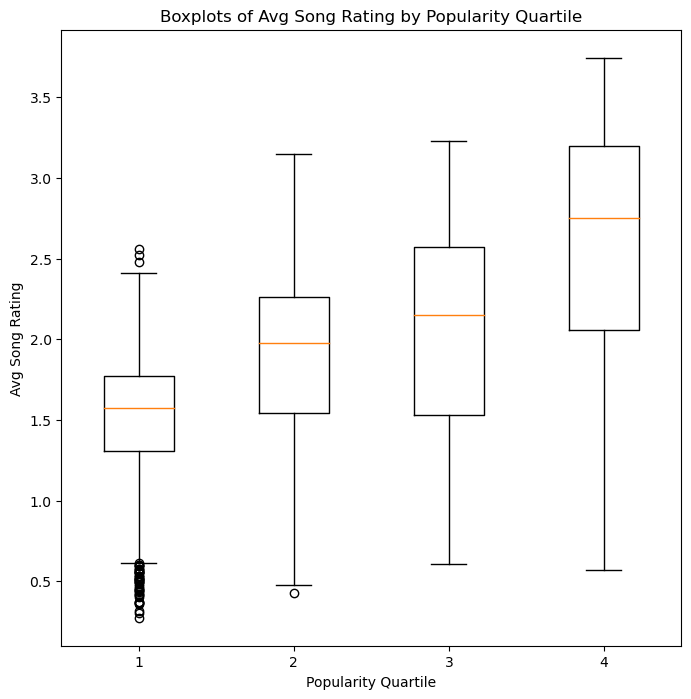

In [497]:
# Visualize this result
fig, ax = plt.subplots(figsize=(8, 8))

# Get the data by rating
rating_data_avg = [test_df[test_df['Popularity Quartile'] == x]['Avg Song Rating'] for x in range(0, 4)]

# We want a boxplot of polarity
ax.boxplot(rating_data_avg)

# Subset polarity by ratings
ax.set_xlabel('Popularity Quartile')
ax.set_ylabel('Avg Song Rating')
ax.set_title('Boxplots of Avg Song Rating by Popularity Quartile')

In [498]:
# Run the Kruskal-Wallis
h, p = stats.kruskal(rating_data_avg[0], rating_data_avg[1], rating_data_avg[2], rating_data_avg[3])
print("H Statistic: " + str(h))
print("P-Value: " + str(p))

H Statistic: 1062.9955699991058
P-Value: 3.88202744945134e-230


In [499]:
# Get the top 10
greatest_hits = song_avg.sort_values(ascending=False)[:10]
greatest_hits.name = 'Average Rating' # the indices are the greatest hits

# Grab rating count for greatest hits
rating_counts_greatest_hits = len(user_df[greatest_hits.index]) - user_df[greatest_hits.index].isna().sum()
rating_counts_greatest_hits.name = 'Rating Count'

# Get the top 10 songs
popularity_model = popularity_df.loc[greatest_hits.index]
popularity_model = pd.concat([popularity_model, greatest_hits, rating_counts_greatest_hits], axis=1)
popularity_model

,songNumber,artists,album_name,track_name,popularity,duration,explicit,danceability,energy,key,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,Average Rating,Rating Count
2260,2260,Red Hot Chili Peppers,By the Way (Deluxe Edition),Can't Stop,82,269000,False,0.618,0.938,9,...,0.0456,0.017900,0.000000,0.1670,0.875,91.455,4,alt-rock,3.744554,1010
2562,2562,The Offspring,"Rise And Fall, Rage And Grace","You're Gonna Go Far, Kid",81,177826,True,0.550,0.917,0,...,0.0638,0.004280,0.000000,0.1970,0.601,126.115,4,alt-rock,3.743202,993
2003,2003,The Neighbourhood,I Love You.,Sweater Weather,93,240400,False,0.612,0.807,10,...,0.0336,0.049500,0.017700,0.1010,0.398,124.053,4,alt-rock,3.729651,1032
2011,2011,WALK THE MOON,TALKING IS HARD,Shut Up and Dance,83,199080,False,0.578,0.866,1,...,0.0619,0.007010,0.000000,0.2570,0.619,128.038,4,alt-rock,3.729124,982
3253,3253,Gorillaz;Tame Impala;Bootie Brown,New Gold (feat. Tame Impala and Bootie Brown),New Gold (feat. Tame Impala and Bootie Brown),82,215149,True,0.695,0.923,1,...,0.0522,0.042500,0.046900,0.1160,0.551,108.014,3,alternative,3.727451,1020
3201,3201,Evanescence,Fallen,Bring Me To Life,82,235893,False,0.331,0.943,4,...,0.0698,0.007210,0.000002,0.2420,0.296,94.612,4,alternative,3.712598,1016
3007,3007,Linkin Park,Meteora,Numb,83,185586,False,0.496,0.863,9,...,0.0381,0.004600,0.000000,0.6390,0.243,110.018,4,alternative,3.685801,993
2009,2009,Nirvana,Nevermind (Remastered),Smells Like Teen Spirit,83,301920,False,0.502,0.912,1,...,0.0564,0.000025,0.000173,0.1060,0.720,116.761,4,alt-rock,3.677518,983
2770,2770,The Offspring,Americana,The Kids Aren't Alright,81,180160,False,0.523,0.943,1,...,0.0337,0.007040,0.000038,0.0579,0.766,99.607,4,alt-rock,3.672234,958
3256,3256,System Of A Down,Toxicity,Chop Suey!,83,210240,False,0.417,0.934,7,...,0.1190,0.000278,0.001500,0.1320,0.287,127.066,4,alternative,3.661677,1002


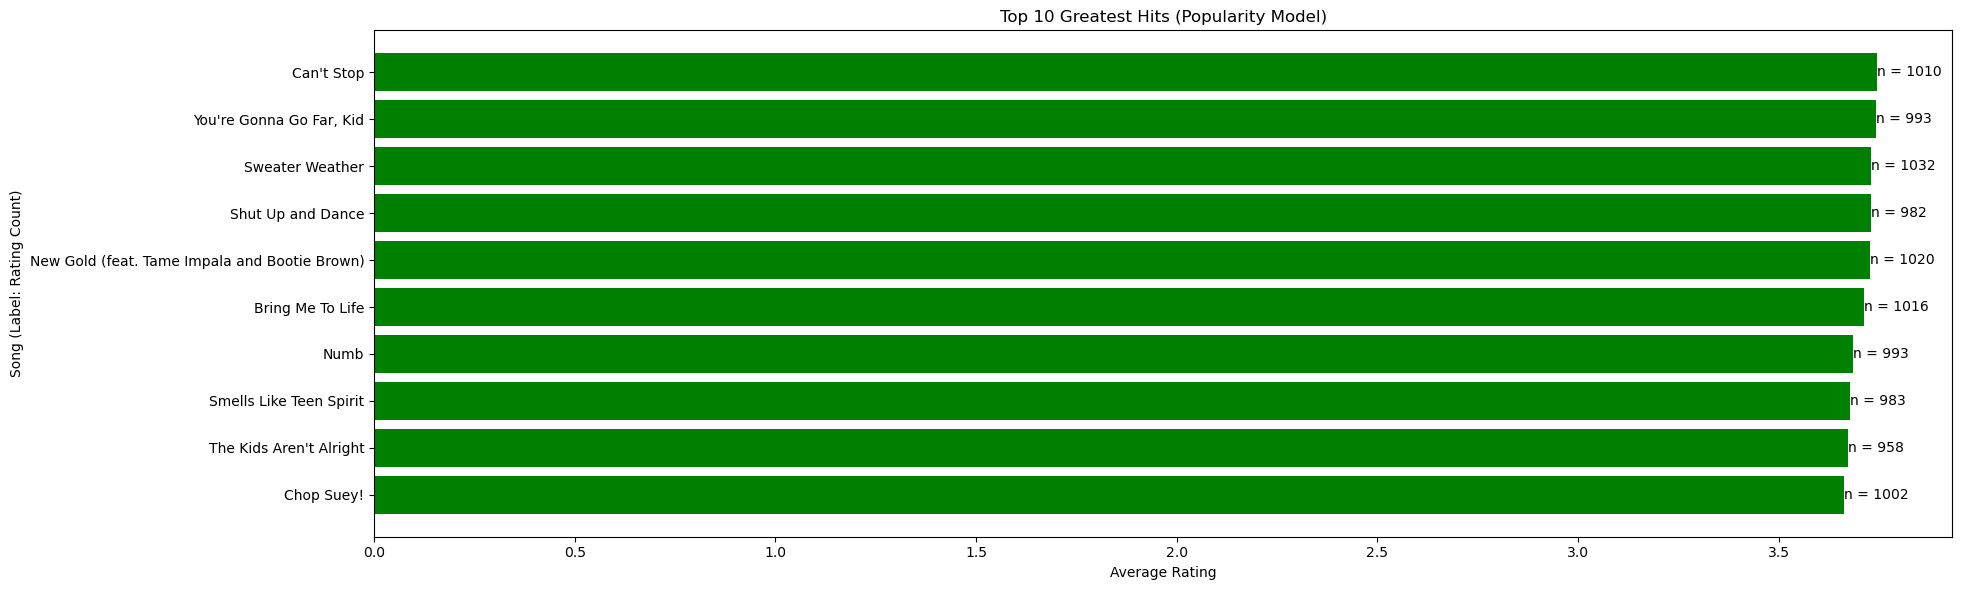

In [500]:
# Show bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Get the x, y axes
y_avg = [str(x) for x in popularity_model['track_name']]
rating_avg = popularity_model['Average Rating']
rating_count = ['n = ' + str(x) for x in popularity_model['Rating Count']]

# Generate bar chart
hbars_avg = ax.barh(y_avg, rating_avg, align='center', color='green', label=rating_count)

ax.set_yticks(y_avg)
ax.invert_yaxis() # Invert to show top first
ax.bar_label(hbars_avg, labels=[str(x) for x in rating_count])
ax.set_xlabel('Average Rating')
ax.set_ylabel('Song (Label: Rating Count)')
ax.set_title('Top 10 Greatest Hits (Popularity Model)')

fig.tight_layout(rect=[0, 0, 2, 1]) # Adjust padding

# Q10

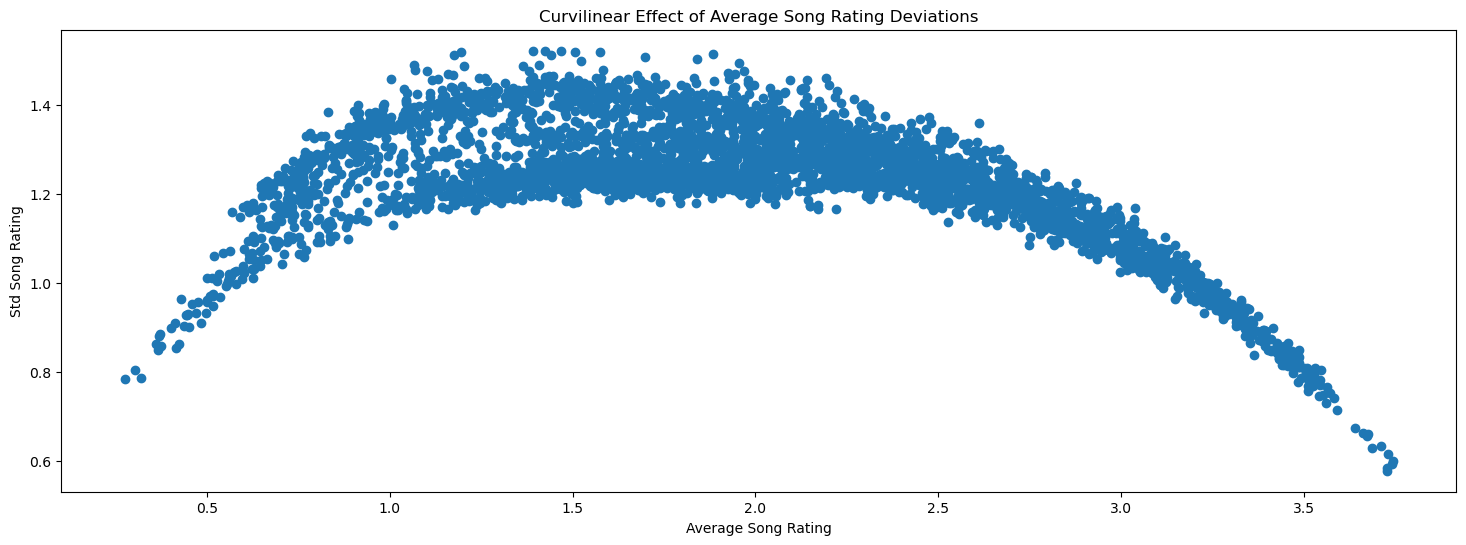

In [501]:
# Prevent clashing
from surprise.model_selection import GridSearchCV
# See mean and std of ratings (for motivation)
fig, ax = plt.subplots(figsize=(18,6))

song_std = user_df.std()

ax.scatter(song_avg, song_std)
ax.set_xlabel('Average Song Rating')
ax.set_ylabel('Std Song Rating') # Strong curvilinear here
plt.title('Curvilinear Effect of Average Song Rating Deviations')
plt.show()

In [502]:
# Get the data in a user, item, rating format
# Remove NAs for training (explicit feedback)
stack_df = pd.DataFrame(user_df.stack())
stack_df = stack_df.reset_index()
stack_df.columns = ['userId', 'songId', 'rating']

# Store for testing
stack_df_test = pd.DataFrame(user_df.stack(dropna=False))
stack_df_test = stack_df_test.reset_index()
stack_df_test.columns = ['userId', 'songId', 'rating']

stack_df.head(), stack_df_test.head()

(   userId  songId  rating
 0       0      24     2.0
 1       0      28     0.0
 2       0      39     0.0
 3       0      40     1.0
 4       0      57     1.0,
    userId  songId  rating
 0       0       0     NaN
 1       0       2     NaN
 2       0       3     NaN
 3       0       4     NaN
 4       0       5     NaN)

In [503]:
# Keep hold out for predictions
train_df, val_df = train_test_split(stack_df, test_size=0.2, random_state=seed)
val_df = val_df.reset_index()

test_df = train_test_split(stack_df_test, test_size=0.2, random_state=seed)[1]
test_df = test_df.reset_index()

In [504]:
# Load data into reader object
reader = Reader(rating_scale=(0,4))

train_data = Dataset.load_from_df(train_df[['userId', 'songId', 'rating']], reader)

In [505]:
# Set hyperparameter grid
# Set hyperparameter grid
parameter_grid = {'n_epochs': np.arange(5, 15, 5),
                  'lr_all': np.arange(0.001, 0.1 , 0.02),
                  'reg_all': np.arange(0.001, 1, 0.2),
                  'random_state': [seed]}

In [507]:
# Apply SVD algorithm to decompose the ratings matrix
grid = GridSearchCV(SVD, param_grid=parameter_grid, measures=["rmse"], cv=5, refit=True)

# Get results
grid.fit(train_data)

print(grid.best_score['rmse'])

1.0733352380325734


In [508]:
# See best performing parameters
grid.best_params

{'rmse': {'n_epochs': 10,
  'lr_all': 0.021,
  'reg_all': 0.201,
  'random_state': 7}}

In [509]:
# Predict for test set, no NAs
series = []
for i in range(len(val_df)):
    series.append(grid.predict(val_df['userId'].iloc[i], val_df['songId'][i])[3])

val_df['est'] = series

# Predict for test set, NAs
series = []
for i in range(len(test_df)):
    series.append(grid.predict(test_df['userId'].iloc[i], test_df['songId'][i])[3])

test_df['est'] = series

In [510]:
val_df['userId'].value_counts() # We can recommend 10 songs to each user

1898    114
2907    114
4336    114
4169    114
555     114
       ... 
1843     54
964      53
3152     52
7044     52
2579     52
Name: userId, Length: 10000, dtype: int64

In [511]:
# Retrieve top 10 estimated ratings
recommender = val_df.groupby('userId').apply(lambda x: x.nlargest(10, 'est'))
recommender.head(20)

index  userId  songId  rating       est
userId                                                
0      84884     420       0    2003     4.0  3.057404
       162255    385       0    2001     4.0  3.013028
       139931    266       0    3931     4.0  2.723932
       13172     225       0    2860     4.0  2.664554
       717090    387       0    2363     2.0  2.657131
       171121    356       0    3219     3.0  2.599031
       660846    228       0    2898     2.0  2.583745
       501405    370       0    2958     3.0  2.560865
       487897    417       0    2920     4.0  2.401254
       273646    397       0    2055     2.0  2.317931
1      523188    622       1    2908     4.0  3.551152
       104251    821       1    2470     4.0  3.520870
       311377    624       1    2963     4.0  3.451267
       628552    801       1    2111     4.0  3.348610
       827128    480       1     679     4.0  3.323171
       95275     625       1    2966     2.0  3.317592
       218887    648       1    3800     4.0  3.265651
       223871    783       1    2252     3.0  3.242835
       662472    758       1    2053     4.0  3.188098
       145253    613       1    2782     1.0  2.993576

In [512]:
# Get median of data to determine "positive" interactions
median = stack_df_test['rating'].median() # 2.0

# Get average precision per user
def average_precision(actual):
  average_precision = 0.0

  # List of T/F values corresponding to every predicted movie indicating whether it is a positive interaction or not
  relevant_inds = np.asarray([x > median for x in actual])

  num_relevant = np.sum(relevant_inds*1) # k-sized array [T, F ...  T] or [1, 0 ... 1] # How many are relevant to the user, that they like

  if num_relevant == 0: # if no trues, then return 0
    return 0

  #  precision calculated at each index i of the predicted list.
  # Precision at index i is the number of relevant items found in the top i+1 predictions divided by i+1
  precision_at_k = np.asarray([(np.sum(relevant_inds[:i+1]*1.0)/(i+1)) for i in range(len(actual))]) # Get the relevant at k, % # this was 10

  for ind in range(len(actual)):
    if relevant_inds[ind]: # So you only sum items where there is a positive
      average_precision += precision_at_k[ind]

  average_precision /= num_relevant # Then just average them
  return average_precision

In [513]:
def mean_average_precision(actual, actual_df):
  # Here, actual/ground truth will be of the shape (num_users, num_movies)
  # We will run the average_precision function for every user and then take the mean of those values
 
  mean_average_precision = 0.0

  # For each user
  for group_data in actual_df.groupby(level='userId'):
      
      ap = average_precision(group_data[1]['rating'])

      mean_average_precision += ap

  mean_average_precision /= len(actual)

  return mean_average_precision

In [514]:
# Find MAP for explicit rating data only
mean_average_precision(recommender['rating'], recommender)

0.08619042317649331

In [515]:
# Run comparison with popularity model
recs_list = [x for x in popularity_model['songNumber']] * 10000

# Stitch to recommender dataframe and run
pop_model = stack_df_test[stack_df_test['songId'].isin(popularity_model['songNumber'])]
pop_model.dropna(inplace=True)
pop_model.set_index(['userId', pop_model.index], inplace=True)

# Run MAP on popularity model
mean_average_precision(pop_model['rating'], pop_model)

0.6207664820191097

In [516]:
test_df['userId'].value_counts() # We can recommend 10 to each user

5222    933
1545    929
9236    926
987     921
628     919
       ... 
9513    743
5539    742
1905    738
8697    730
384     727
Name: userId, Length: 10000, dtype: int64

In [517]:
# Retrieve top 10 for NA data
recommender_test = test_df.groupby('userId').apply(lambda x: x.nlargest(10, 'est')) # start here
len(recommender_test['rating']), recommender_test['rating'].isna().sum()

(100000, 90101)

In [518]:
recommender_test.head(20)

index  userId  songId  rating       est
userId                                                 
0      1958613   4125       0    2562     NaN  3.103662
       2143811   2208       0    3256     NaN  3.000978
       2849117   3763       0    3007     NaN  2.958208
       5343371   3334       0    2558     4.0  2.939808
       3901288   3492       0    2365     NaN  2.931990
       5907430   2065       0    2954     NaN  2.923202
       586065    3240       0    2607     NaN  2.912011
       4534205   1898       0    2700     NaN  2.893436
       3457496   2338       0    3869     3.0  2.876830
       4407362   2366       0    3924     NaN  2.863613
1      5557212   6344       1    3201     4.0  3.813973
       261232    8273       1    2562     NaN  3.800668
       6113293   6387       1    3454     NaN  3.766009
       806892    6356       1    3256     NaN  3.726140
       3477234   6527       1    3972     NaN  3.682282
       8128209   7482       1    2558     NaN  3.682064
       3475495   8295       1    2452     4.0  3.674440
       4423338   7558       1    2615     NaN  3.664993
       7575428   7625       1    2204     NaN  3.656581
       3511595   7640       1    2365     NaN  3.650418

In [519]:
# Get MAP on NA data
drop_na = recommender_test.dropna()
mean_average_precision(drop_na['rating'], drop_na)

0.6022867068502986

Text(0, 0.5, 'Frequency')

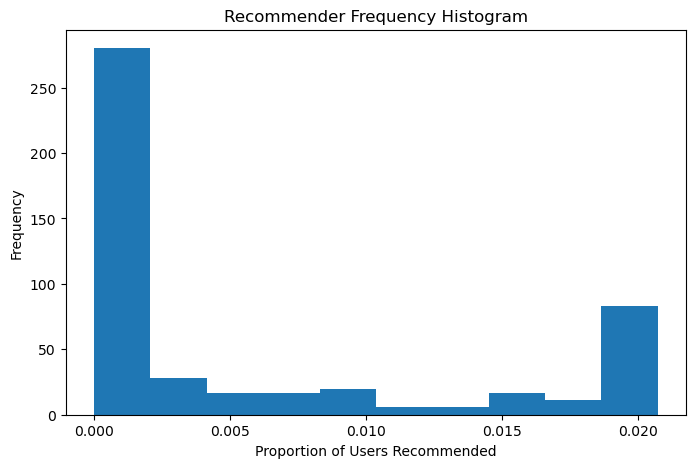

In [520]:
# Compare to greatest hits
songs = recommender_test['songId'].value_counts(ascending=False, normalize=True).to_frame().reset_index()
songs.columns = ['songNumber', 'Proportion']

song_titles = spotify_df.loc[songs['songNumber']]['track_name']
song_titles = song_titles.reset_index()

# Show histogram of recommendation frequency (popularity model is the same 10 for all)
plt.figure(figsize=(8,5))
plt.hist(songs['Proportion'], density=True)
plt.title('Recommender Frequency Histogram')
plt.xlabel('Proportion of Users Recommended')
plt.ylabel('Frequency')

In [521]:
# Show proportion of recommendations that are greatest hits
sum(recommender_test['songId'].isin(popularity_model['songNumber'])) / len(recommender_test['userId']), len(recommender_test['userId'])

(0.19974, 100000)

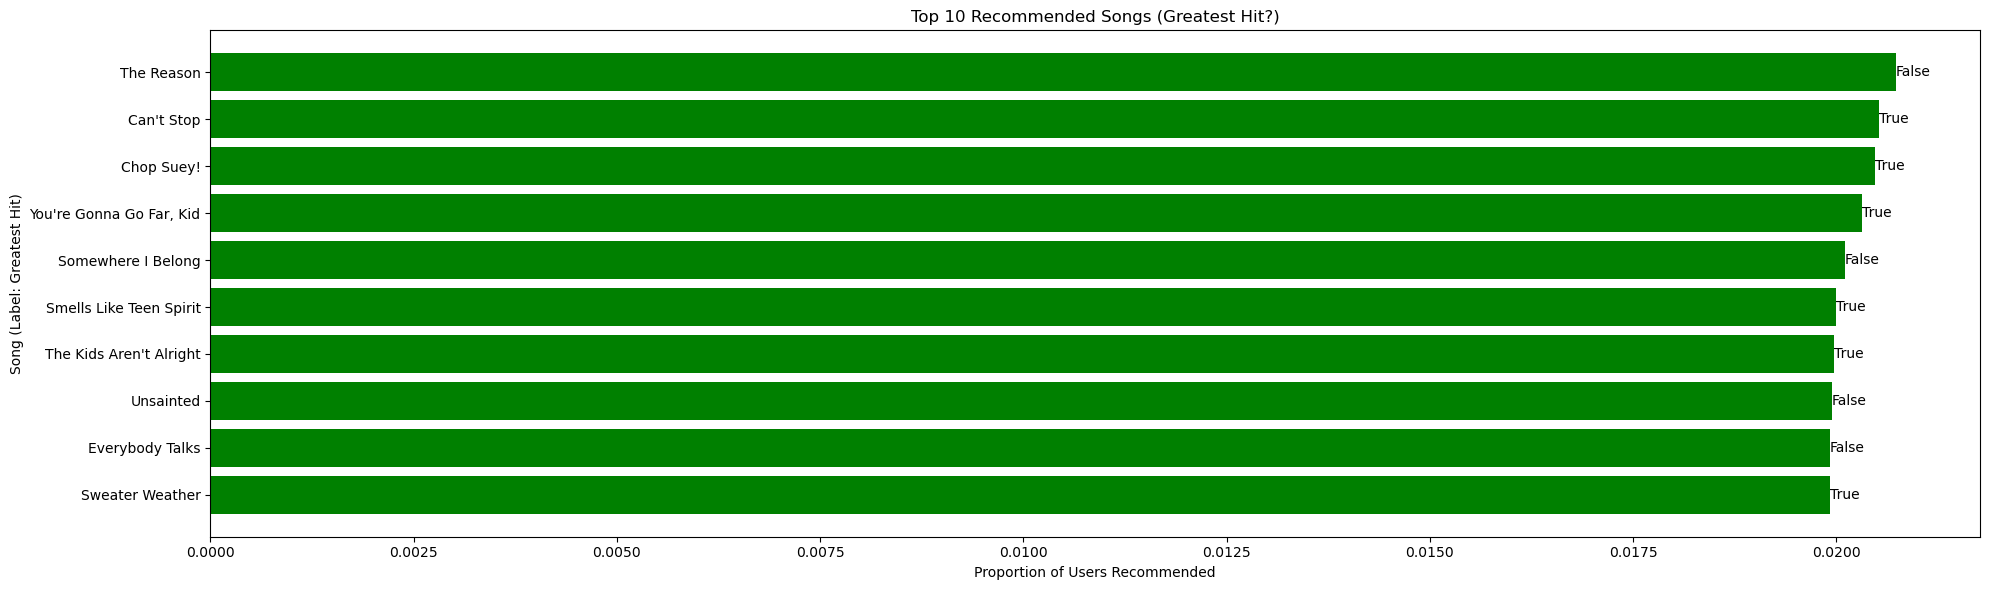

In [522]:
# Show song titles
songs['Song Title'] = song_titles['track_name']
songs['Greatest Hit'] = songs['Song Title'].isin(popularity_model['track_name'])
songs_head = songs.head(10)

# Show bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Generate bar chart
hbars_avg = ax.barh(songs_head['Song Title'], songs_head['Proportion'], align='center', color='green', label=songs_head['Greatest Hit'])

ax.set_yticks(songs_head['Song Title'])
ax.invert_yaxis() # Invert to show top first
ax.bar_label(hbars_avg, labels=songs_head['Greatest Hit'])
ax.set_xlabel('Proportion of Users Recommended')
ax.set_ylabel('Song (Label: Greatest Hit)')
ax.set_title('Top 10 Recommended Songs (Greatest Hit?)')

fig.tight_layout(rect=[0, 0, 2, 1]) # Adjust padding

# Extra Credit

In [523]:
# Extract data of interest
ec_df = spotify_df[['popularity', 'time_signature']]
ec_df = ec_df[ec_df['time_signature'] != 0]
ec_df.head()

,popularity,time_signature
0,73,4
1,55,4
2,57,4
3,71,3
4,82,4


In [524]:
# Get summary statistics
summary = ec_df.groupby('time_signature').describe()
summary

popularity                                                    
                    count       mean        std  min   25%   50%   75%    max
time_signature                                                               
1                   435.0  29.832184  18.636762  0.0  18.0  26.0  45.0   80.0
3                  3832.0  30.414405  20.604693  0.0  18.0  27.0  47.0   89.0
4                 46903.0  33.399228  21.883845  0.0  18.0  34.0  50.0  100.0
5                   821.0  31.249695  19.251031  0.0  19.0  28.0  46.0   81.0

Text(0.5, 1.0, 'Boxplots of Popularity by Time Signature')

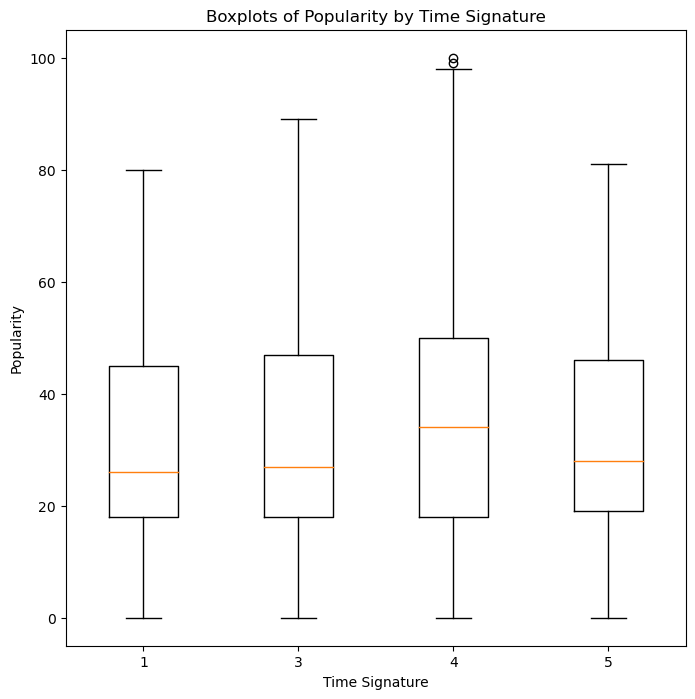

In [525]:
# Visualize this result
fig, ax = plt.subplots(figsize=(8, 8))

# Get the data by rating
pop_avg = [ec_df[ec_df['time_signature'] == x]['popularity'] for x in summary.index]

# We want a boxplot of polarity
ax.boxplot(pop_avg)

# Subset polarity by ratings
ax.set_xticklabels([str(x) for x in summary.index])
ax.set_xlabel('Time Signature')
ax.set_ylabel('Popularity')
ax.set_title('Boxplots of Popularity by Time Signature')

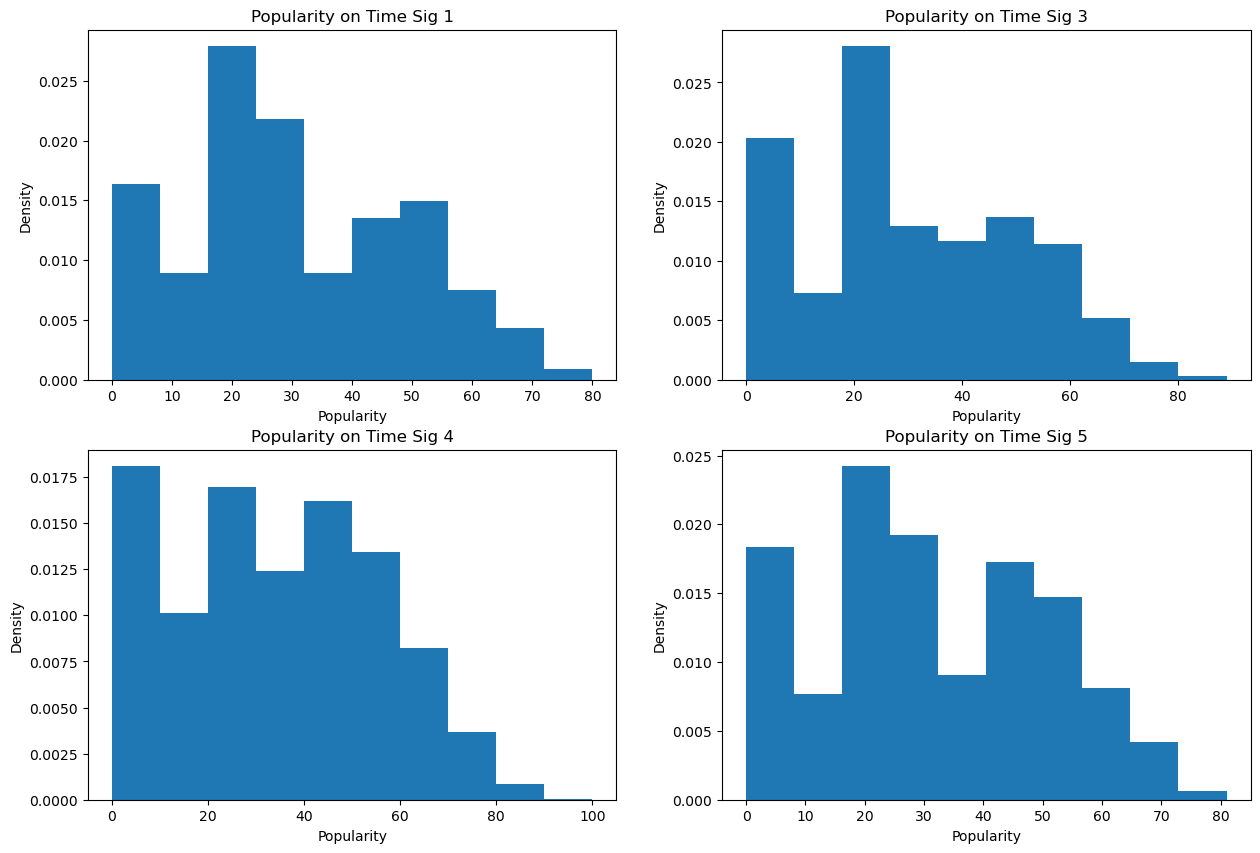

In [526]:
# Plot histograms of both
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.hist(pop_avg[0], density=True)
plt.xlabel('Popularity')
plt.ylabel('Density')
plt.title('Popularity on Time Sig 1')


plt.subplot(2, 2, 2)
plt.hist(pop_avg[1], density=True)
plt.xlabel('Popularity')
plt.ylabel('Density')
plt.title('Popularity on Time Sig 3')

plt.subplot(2, 2, 3)
plt.hist(pop_avg[2], density=True)
plt.xlabel('Popularity')
plt.ylabel('Density')
plt.title('Popularity on Time Sig 4')

plt.subplot(2, 2, 4)
plt.hist(pop_avg[3], density=True)
plt.xlabel('Popularity')
plt.ylabel('Density')
plt.title('Popularity on Time Sig 5')
plt.show()

In [527]:
# Run Kruskal Wallis test on all groups
h, p = stats.kruskal(pop_avg[0], pop_avg[1], pop_avg[2], pop_avg[3])
print("H Statistic: " + str(h))
print("P-Value: " + str(p))

H Statistic: 81.09801919330573
P-Value: 1.7844054648874662e-17


In [528]:
# Run Kruskal Wallis test on 3 groups
h, p = stats.kruskal(pop_avg[0], pop_avg[1], pop_avg[3])
print("H Statistic: " + str(h))
print("P-Value: " + str(p))

H Statistic: 2.5167738410499085
P-Value: 0.2841119522239301


In [529]:
# Run Mann-Whitney on time signature 4 v rest of the data
data = ec_df[ec_df['time_signature'] != 4]['popularity']

u ,p = stats.mannwhitneyu(data, pop_avg[2], alternative="less")
print("U Statistic: " + str(u))
print("P-Value: " + str(p))

U Statistic: 110282139.5
P-Value: 2.83220489305996e-19
